# STAT3612 Group Project

The theme of this semester is interpretable machine learning (IML) with applications to a real datacase study.

For an IML model, both **prediction accuracy and model explainability are equally important**. 
You will need to take both objectives into account when building models in this project.

The data includes about 10,400 anonymized Home Equity Line of Credit (HELOC) loans,together with 23 attributes. 

Note that in the second Excel file the monotonicity constraints are included in the data dictionary, which are based on the prior knowledge about the feature-target effect. 

**Build your IML models based only on the training data**.  
There is no restriction in the choice of feature engineering techniques or machine learning algorithms. 

The final model evaluations will be based on three aspects:
1.  Prediction accuracy as tested on the remaining 20% dataset
2.  Global interpretability about the model effects
3.  Local interpretability about individual predictions (Good/Bad cases from testing data).

## Importing Libraries

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score,auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tabulate import tabulate # printing output as tables

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Reading datasets

In [211]:
pd.set_option('display.max_colwidth', -1) # show complete variable names
heloc = pd.read_csv('HelocData.csv')
dataDict = pd.read_excel('HelocDataDict2.xlsx')
dataDict['Description'] = dataDict['Description'].apply(
    lambda x: x.split('.')[0] if '.' in x else x)[1:] # Only extract the first sentence

In [212]:
#dataDict

In [213]:
# impute the missing values with the mean of each column 
features = heloc.columns.tolist()[1:] # list of x_i 
heloc[features] = heloc[features][heloc[features] >= 0].fillna(heloc[features].mean())


In [214]:
## explain what this does

median=np.zeros(23)

for i in range(0,23):
    median[i]= np.median(heloc[features[i]][(heloc[features[i]] > -7)])   
    
for i in range(0,23):
    heloc=heloc[heloc[features[i]] > -9] 
    heloc[features[i]].where(heloc[features[i]]>-8, median[i], inplace=True)
    heloc[features[i]].where(heloc[features[i]]>-7, other=100, inplace=True)


In [215]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
heloc['RiskFlag'] = label_encoder.fit_transform(heloc['RiskFlag']) # encode 0/1 to RiskFlag

In [216]:
# we dont want to include x9 since over half of its features are 'missing'

In [217]:
GID = 20190006 # group Id
np.random.seed(GID) # set GID as random seed

# create binary 0/1 'good/bad' variable in dataframe
y = heloc['RiskFlag']
X = heloc.drop('RiskFlag', axis=1)

In [45]:
# Compare Algorithms

models = [('LR', LogisticRegression(solver='newton-cg',C=1e6)), 
          ('CART', DecisionTreeClassifier()), 
          ('SVM', SVC(gamma='scale', kernel='rbf')), 
          ('XGB', XGBClassifier())
         ]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
   

KeyboardInterrupt: 

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the analysis above, logistic regression performs as well as the two black box models, support vector machines and gradient boosted trees.

Logisitic regression gives us a natural way of interpreting the model output- 'probabilities' of repaying a loan.  

preprocessing finished

---

---

## EDA and feature engineering

**NOTE**
10. Max Delq/Public Records Last 12 Months: Values 0-7 are monotonically decreasing (step function)
11. Max Delinquency Ever: Values 2-8 are monotonically decreasing (step function)

In [ ]:
# Use the monotonicity constraints in our preprocessing

In [110]:
dataDict[dataDict['Monotonicity Constraint w.r.t. Prob(Bad = 1)'] == 'Monotonically Increasing']

,Variable Names,Description,Monotonicity Constraint w.r.t. Prob(Bad = 1)
6,x6,Number Trades 60+ Ever,Monotonically Increasing
7,x7,Number Trades 90+ Ever,Monotonically Increasing
13,x13,Number of Trades Open in Last 12 Months,Monotonically Increasing
16,x16,Number of Inq Last 6 Months,Monotonically Increasing
17,x17,Number of Inq Last 6 Months excl 7days,Monotonically Increasing
18,x18,Net Fraction Revolving Burden,Monotonically Increasing
19,x19,Net Fraction Installment Burden,Monotonically Increasing
22,x22,Number Bank/Natl Trades w high utilization ratio,Monotonically Increasing


In [109]:
dataDict[dataDict['Monotonicity Constraint w.r.t. Prob(Bad = 1)'] == 'Monotonically Decreasing']

,Variable Names,Description,Monotonicity Constraint w.r.t. Prob(Bad = 1)
1,x1,Consolidated version of risk markers,Monotonically Decreasing
2,x2,Months Since Oldest Trade Open,Monotonically Decreasing
3,x3,Months Since Most Recent Trade Open,Monotonically Decreasing
4,x4,Average Months in File,Monotonically Decreasing
5,x5,Number Satisfactory Trades,Monotonically Decreasing
8,x8,Percent Trades Never Delinquent,Monotonically Decreasing
9,x9,Months Since Most Recent Delinquency,Monotonically Decreasing
15,x15,Months Since Most Recent Inq excl 7days,Monotonically Decreasing


In [ ]:
''' 
fig = plt.figure(figsize=(15,20))
for i in range(1,len(x_cols)+1):
    plt.subplot(6,4,i)
    sns.boxplot( X_train[x_cols[i-1]], heloc.RiskFlag, )
plt.tight_layout()
plt.show()
'''

In [218]:
# new features 
# comment on what the new variables mean
heloc_tmp=heloc.copy()

heloc_tmp['x24']=(heloc['x2']-heloc['x3'])/heloc['x4']

heloc_tmp['x25']=(heloc['x2']-heloc['x9'])/heloc['x4']

heloc_tmp['x26']=heloc['x5']/heloc['x4']

In [51]:
corr = heloc.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
RiskFlag,1,0.45,0.21,0.045,0.24,0.14,-0.16,-0.13,0.25,0.016,0.23,0.21,0.098,-0.074,-0.14,0.16,-0.14,-0.13,-0.34,-0.085,-0.12,-0.051,-0.21,-0.27
x1,0.45,1,0.25,0.14,0.33,0.0045,-0.4,-0.33,0.52,0.018,0.57,0.51,-0.034,-0.18,-0.16,0.16,-0.2,-0.2,-0.61,-0.14,-0.33,-0.17,-0.41,-0.45
x2,0.21,0.25,1,0.1,0.68,0.24,-0.0089,-0.023,0.043,0.031,-0.0032,0.0011,0.27,-0.1,-0.19,0.086,-0.1,-0.099,-0.17,-0.1,0.12,-0.034,0.021,-0.21
x3,0.045,0.14,0.1,1,0.4,-0.25,0.029,0.03,-0.11,-0.039,0.0066,0.017,-0.22,-0.44,-0.0096,0.044,-0.16,-0.17,-0.056,-0.23,-0.16,-0.19,-0.094,-0.0068
x4,0.24,0.33,0.68,0.4,1,0.11,0.042,0.018,-0.04,0.03,-0.01,-0.03,0.089,-0.35,-0.2,0.088,-0.18,-0.17,-0.19,-0.21,0.013,-0.14,-0.033,-0.21
x5,0.14,0.0045,0.24,-0.25,0.11,1,-0.11,-0.11,0.27,0.025,-0.0041,0.04,0.85,0.31,-0.13,0.035,0.1,0.1,-0.07,0.12,0.48,0.38,0.26,-0.23
x6,-0.16,-0.4,-0.0089,0.029,0.042,-0.11,1,0.89,-0.52,0.15,-0.41,-0.57,-0.021,-0.048,0.12,-0.047,0.046,0.046,0.092,0.026,-0.042,0.049,-0.017,0.12
x7,-0.13,-0.33,-0.023,0.03,0.018,-0.11,0.89,1,-0.36,0.14,-0.35,-0.48,-0.035,-0.039,0.11,-0.039,0.05,0.05,0.065,0.03,-0.053,0.036,-0.027,0.1
x8,0.25,0.52,0.043,-0.11,-0.04,0.27,-0.52,-0.36,1,-0.085,0.51,0.64,0.17,0.16,-0.12,0.081,0.014,0.015,-0.16,0.055,0.086,0.068,0.04,-0.17
x9,0.016,0.018,0.031,-0.039,0.03,0.025,0.15,0.14,-0.085,1,0.073,-0.34,0.03,0.049,0.032,0.015,0.016,0.017,0.029,0.048,0.0075,0.029,0.011,0.02


---

# Feature Selection

https://mlwhiz.com/blog/2019/08/07/feature_selection/

In [219]:
features_tmp = heloc_tmp.columns.tolist()[1:]
num_feats=len(features_tmp)
X = heloc_tmp.drop('RiskFlag', axis=1)
y = heloc_tmp['RiskFlag']

In [220]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

26 selected features


In [221]:
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=LogisticRegression(solver='newton-cg'), 
                   n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

26 selected features


In [222]:
from sklearn.feature_selection import SelectFromModel

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

19 selected features


In [223]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

12 selected features


In [224]:
from sklearn.feature_selection import SelectFromModel

xgbc=XGBClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_xgb_selector = SelectFromModel(xgbc, max_features=num_feats)
embeded_xgb_selector.fit(X, y)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

8 selected features


In [225]:
feature_selection_df = pd.DataFrame(
    {'Feature':features_tmp, 'Chi-2':chi_support, 
     'RFE':rfe_support, 'Logistics':embeded_lr_support,
     'Random Forest':embeded_rf_support, 'XGB':embeded_xgb_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display features by importance
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [146]:
feature_selection_df

,Feature,Chi-2,RFE,Logistics,Random Forest,XGB,Total
1,x18,True,True,True,True,True,5
2,x1,True,True,True,True,True,5
3,x8,True,True,True,True,False,4
4,x5,True,True,True,True,False,4
5,x4,True,True,True,True,False,4
6,x26,True,True,True,True,False,4
7,x23,True,True,True,True,False,4
8,x22,True,True,True,False,True,4
9,x2,True,True,True,True,False,4
10,x15,True,True,True,False,True,4


In [226]:
###
drop=feature_selection_df[feature_selection_df['Total'] <4]['Feature'].values
print(drop)

heloc = heloc_tmp.drop(drop,axis=1) # update heloc with removed features

['x9' 'x7' 'x6' 'x3' 'x25' 'x24' 'x21' 'x20' 'x19' 'x16' 'x12' 'x17' 'x13']


---

## Model Building

In [227]:
features = heloc.columns.tolist()[1:] # updated list of features

heloc_train, heloc_test = train_test_split(heloc, test_size=0.2, random_state=GID) # 80/20 train/test split

In [228]:
# Binning

import scorecardpy as sc

heloc_train_tmp=heloc_train.copy()
heloc_test_tmp=heloc_test.copy()

for i in range(len(features)):
    bins = sc.woebin(heloc_train_tmp, y='RiskFlag',x=features[i], method='tree')
    breaks = np.insert(bins[features[i]]['breaks'].values.astype(np.float), 0, -np.inf)

    heloc_train_tmp[features[i]] = pd.cut(heloc_train_tmp[features[i]], bins=breaks, right=True)
    heloc_test_tmp[features[i]] = pd.cut(heloc_test_tmp[features[i]], bins=breaks, right=True)

[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...


In [229]:
# Discretize into categorical variables

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for i in range(len(features)):
    heloc_train_tmp[features[i]] = label_encoder.fit_transform(heloc_train_tmp[features[i]])
    heloc_test_tmp[features[i]] = label_encoder.fit_transform(heloc_test_tmp[features[i]])

In [230]:
# split dataset into train and testing for model evaluation
heloc_train=heloc_train_tmp
heloc_test=heloc_test_tmp

X_train = heloc_train.drop('RiskFlag', axis=1)
y_train = heloc_train['RiskFlag']
X_test = heloc_test.drop('RiskFlag', axis=1)
y_test = heloc_test['RiskFlag']

In [232]:
from pygam import LogisticGAM, l, s, f,te  #increased flexibility on our models features.

gam = LogisticGAM()

In [233]:
gam.fit(X_train, y_train)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False)

In [191]:
gam.terms

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept

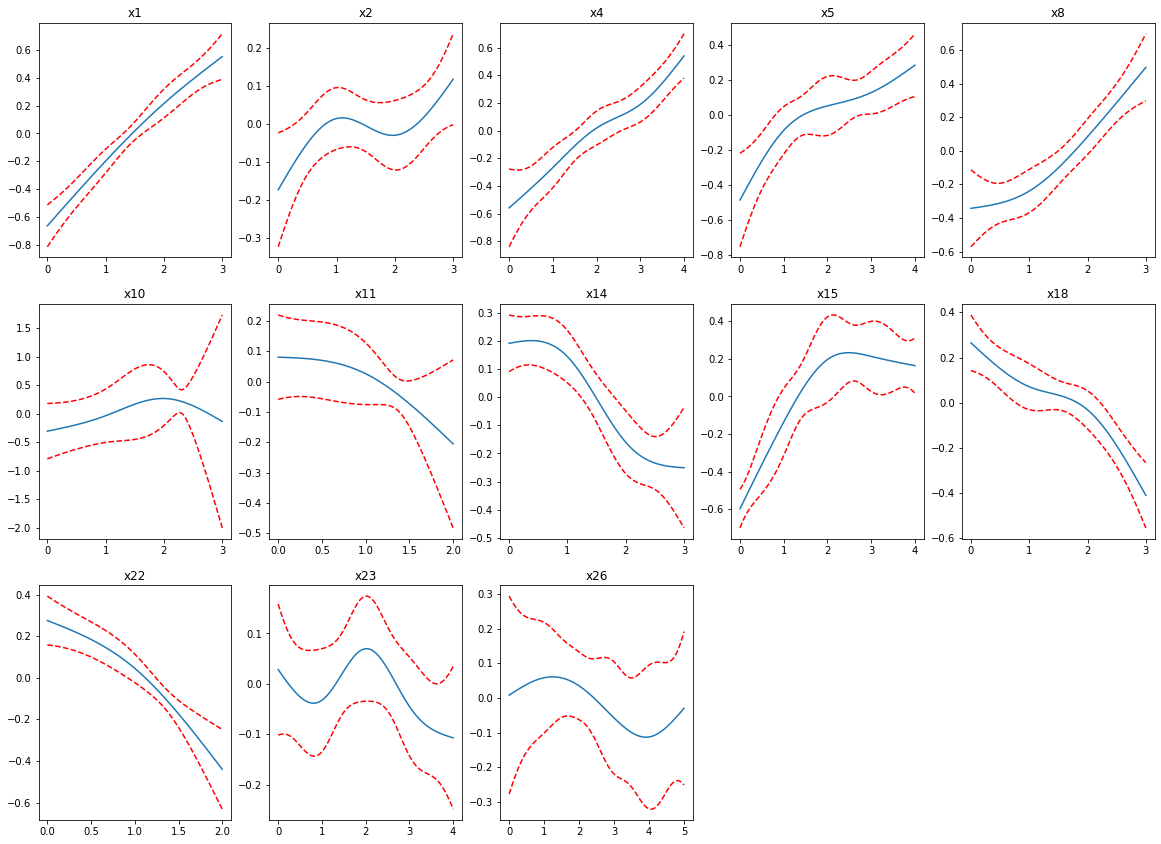

In [234]:
fig = plt.figure(figsize =(20,25))
titles = features

for i in range(len(gam.terms)-1):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax1=plt.subplot(5,5,i+1)
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(titles[i])

In [ ]:
## Hyperparameter tuning
'''

lr = LogisticRegression()
param_grid = dict(penalty = ['l1', 'l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

'''

In [248]:
'''
lgr = LogisticRegression(C=1, penalty='l1')
lgr.fit(X_train, y_train)


'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-248-b0010a508136>, line 3)

## Model Evaluation

In [243]:
y_train_pred = gam.predict_proba(X_train)
y_test_pred = gam.predict_proba(X_test)

acc_train = roc_auc_score(y_train,y_train_pred)
acc_test = roc_auc_score(y_test,y_test_pred)
    
print('The Acc on training set:',acc_train)
print('The Acc on testing set:',acc_test)

The Acc on training set: 0.7974961918135212
The Acc on testing set: 0.7869609766951655


In [236]:
# we will calculate train and test error rates for all models
def error_rate(y_true, X, model):
    y_pred = model.predict(X)
    return 1 - accuracy_score(y_true, y_pred)

print('Training error rate: ',error_rate(y_train, X_train, gam))
print('Test error rate: ', error_rate(y_test, X_test, gam))

Training error rate:  0.27249910362136964
Test error rate:  0.2748565965583174


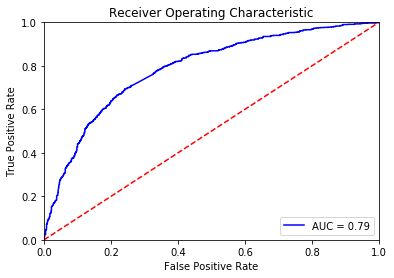

In [156]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
roc_auc